In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/My Drive/Khoa Luan/"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [5]:
import pickle
import pandas as pd
df = pd.read_csv(path+"NTC_SV/NTC_SV_train.csv")
df_test = pd.read_csv(path+'NTC_SV/NTC_SV_test.csv')
# df = pd.concat([df,df_test])
df = df.dropna()
print(df)
print(df_test)

       Unnamed: 0                                             review  label
0               0  đồ_ăn ngon positive hợp_khẩu vị nhiều món nhân...      0
1               1  chè bơ thơm positive có vị ngậy ngậy nhưng lại...      0
2               2  chiều hôm nay mới đi ăn về nghe thiên_hạ đồn q...      0
3               3  mình đặt_hàng qua tin nhắn với cửa_hàng hứa sá...      0
4               4  ghé mấy lần rồi mà không review đi đâu cũng ch...      1
...           ...                                                ...    ...
40756       40756                                              thiếu      0
40757       40757                                                xấu      0
40758       40758                                                 ẩu      0
40759       40759                                                lộn      0
40760       40760                                           hoang_sơ      0

[40760 rows x 3 columns]
      Unnamed: 0                                             r

In [6]:
data = df.review.astype(str)
data = data.to_list()
label = df.label.tolist()
data_test = df_test.review.astype(str)
data_test = data_test.to_list()
label_test = df_test.label.to_list()

In [7]:
import pickle
with open(path + 'glove.model', 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

sequences =  tokenizer.texts_to_sequences(data)
sequences_test =  tokenizer.texts_to_sequences(data_test)

maxlen = 300
data1 = pad_sequences(sequences, maxlen=maxlen)
test1 = pad_sequences(sequences_test, maxlen=maxlen)

# le = LabelEncoder()

# label = le.fit_transform(label)
# labels = label.reshape(-1,1)
# labels_test = le.fit_transform(label_test)
# labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print(data1.shape)
# print('Shape of label tensor:', labels.shape)
x_train,x_val,y_train,y_val = train_test_split(data1,label,test_size=0.15, random_state=48)

unique words : 27954
(40760, 300)


In [9]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(embedding_matrix.shape)
for word, i in word_index.items():
    # print(word)
    try:
        embedding_vector = embeddings_index['word_vectors'][embeddings_index['dictionary'][word]]
    except KeyError:
        embedding_vector = None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

(34558, 300)


In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, Flatten, Dense, Lambda, LSTM, concatenate
import keras.backend as K

In [ ]:
input_text = Input(shape=(maxlen,))

embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(input_text)
text_embed = SpatialDropout1D(0.2)(embedding_layer)

# We shift the document to the right to obtain the left-side contexts
l_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
                                              x[:, :-1]], axis=1))(text_embed)
# We shift the document to the left to obtain the right-side contexts
r_embedding = Lambda(lambda x: K.concatenate([K.zeros(shape=(K.shape(x)[0], 1, K.shape(x)[-1])),
                                              x[:, 1:]], axis=1))(text_embed)
# use LSTM RNNs instead of vanilla RNNs as described in the paper.
forward = LSTM(256, return_sequences=True)(l_embedding)  # See equation (1)
backward = LSTM(256, return_sequences=True, go_backwards=True)(r_embedding)  # See equation (2)
# Keras returns the output sequences in reverse order.
backward = Lambda(lambda x: K.reverse(x, axes=1))(backward)
together = concatenate([forward, text_embed, backward], axis=2)  # See equation (3).

# use conv1D instead of TimeDistributed and Dense
semantic = Conv1D(256, kernel_size=1, activation="tanh")(together)  # See equation (4).
sentence_embed = Lambda(lambda x: K.max(x, axis=1))(semantic)  # See equation (5).  

dense_layer = Dense(256, activation='relu')(sentence_embed)
output = Dense(1, activation='sigmoid')(dense_layer)

model = Model(input_text, output)

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer=Adam(learning_rate=0.001))
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'Test/weights_rcnn_vreview_glove_sentece.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
history = model.fit(x_train,y_train,epochs=10,batch_size=128,verbose = 1,validation_data=[x_val,y_val],callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70784 samples, validate on 12492 samples
Epoch 1/10
70784/70784 [==============================] - 447s 6ms/step - loss: 0.3144 - acc: 0.8676 - val_loss: 0.2648 - val_acc: 0.8935

Epoch 00001: val_acc improved from -inf to 0.89345, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_rcnn_vreview_glove_sentece.h5
Epoch 2/10
70784/70784 [==============================] - 439s 6ms/step - loss: 0.2278 - acc: 0.9099 - val_loss: 0.2443 - val_acc: 0.9027

Epoch 00002: val_acc improved from 0.89345 to 0.90274, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_rcnn_vreview_glove_sentece.h5
Epoch 3/10
70784/70784 [==============================] - 438s 6ms/step - loss: 0.1833 - acc: 0.9306 - val_loss: 0.2514 - val_acc: 0.8999

Epoch 00003: val_acc did not improve from 0.90274
Epoch 4/10
70784/70784 [==============================] - 439s 6ms/step - loss: 0.1461 - acc: 0.9443 - val_loss: 0.2763 - val_acc: 0.9014

Epoch 00004: val_acc did not improve from 0.90274
E

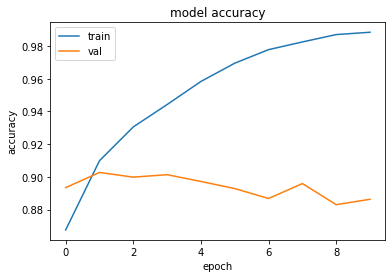

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

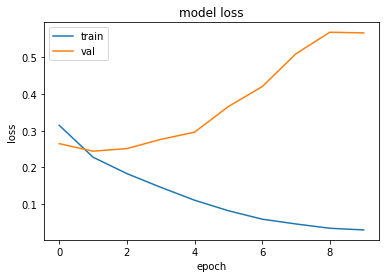

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
from keras.models import load_model
model = load_model(path + 'Test/weights_Textcnn_NCT_SV_glove_sentece.hdf5')
# accr = model.evaluate(test1,label_test)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:
from sklearn import metrics
acc = model.predict(test1)
accr = np.round(acc)
print(metrics.f1_score(label_test, accr))
print(metrics.precision_score(label_test, accr))
print(metrics.recall_score(label_test, accr))

0.7771377935312361
0.6976929196499603
0.877
